In [43]:
# import stuff
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint

import numpy as np
import torch
import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
import json
from textblob import TextBlob
import nltk
from scipy import spatial


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load model

In [44]:
# Load model
from models import InferSent
model_version = 1
MODEL_PATH = "../encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

In [45]:
# Keep it on CPU or put it on GPU
use_cuda = False
model = model.cuda() if use_cuda else model

In [46]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = '../dataset/GloVe/glove.840B.300d.txt' if model_version == 1 else '../dataset/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [47]:
# Load embeddings of K most frequent words
#model.build_vocab_k_words(K=100000)

## Load sentences

In [48]:
sentences = []
with open('data/openbook.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

1326


In [49]:
sentences[:5]

['"A bee is a pollinating animal"',
 '"A bird is a pollinating animal"',
 '"An electrical conductor is a vehicle for the flow of electricity"',
 '"An example of a change in the Earth is an ocean becoming a wooded area"',
 '"An example of a chemical change is acid breaking down substances"']

In [50]:
# Build vocabulary of sentences from openbook text
model.build_vocab(sentences, tokenize=True)

Found 1842(/1846) words with w2v vectors
Vocab size : 1842


## Encode questions and answers

In [10]:
# gpu mode : >> 1000 sentences/s
# cpu mode : ~100 sentences/s

In [51]:
train = pd.read_csv('data/train.tsv', sep='\t')
valid = pd.read_csv('data/test.tsv', sep='\t')

In [52]:
train.shape, valid.shape

((4957, 5), (500, 5))

In [53]:
train.head(3)

,ID,Question Stem,Choices,Complete Question,Answer Key
0,7-980,The sun is responsible for,(A) puppies learning new tricks (B) children g...,The sun is responsible for (A) puppies learnin...,D
1,7-584,When standing miles away from Mount Rushmore,(A) the mountains seem very close (B) the moun...,When standing miles away from Mount Rushmore (...,D
2,7-870,When food is reduced in the stomach,(A) the mind needs time to digest (B) take a s...,When food is reduced in the stomach (A) the mi...,C


In [54]:
train['Choices']= train['Choices'].apply(lambda x: x.replace('(' , ',(')).astype('str')
question = train['Question Stem']
answers = list(train["Choices"])

answer_list = [x for xs in answers for x in xs.split(',')]
answer_list_clean = ['nan' if x=='' else x for x in answer_list]
clean_sentence_w_nan = list(filter(lambda a: a != 'nan', answer_list_clean))

cleaned_answer_list_A = []
cleaned_answer_list_B = []
cleaned_answer_list_C = []
cleaned_answer_list_D = []
for item in clean_sentence_w_nan:
    if item.startswith("(A)"):
        cleaned_answer_list_A.append(item)
    elif item.startswith("(B)"):
         cleaned_answer_list_B.append(item)
    elif item.startswith("(C)"):
         cleaned_answer_list_C.append(item)        
    elif item.startswith("(D)"):
         cleaned_answer_list_D.append(item)

cleaned_answer_list_D.pop()   
#print(len(cleaned_answer_list_B),len(cleaned_answer_list_A),len(cleaned_answer_list_D),len(cleaned_answer_list_C)) 

dfanswers = pd.DataFrame(
    {'questions': question,
     'opitonA': cleaned_answer_list_A,
     'opitonB': cleaned_answer_list_B,
     'opitonC': cleaned_answer_list_C,
     'opitonD': cleaned_answer_list_D,
    })

In [58]:
answers_optionA = list(dfanswers["opitonA"]) 
answers_optionB = list(dfanswers["opitonB"]) 
answers_optionC = list(dfanswers["opitonC"]) 
answers_optionD = list(dfanswers["opitonD"]) 


dict_embeddings_answers_optionA = {}
dict_embeddings_answers_optionB = {}
dict_embeddings_answers_optionC = {}
dict_embeddings_answers_optionD = {}

for i in range(len(answers_optionA)):
#     print(answers_optionA[i])
    dict_embeddings_answers_optionA[answers_optionA[i]] = model.encode([answers_optionA[i]], tokenize=True)

for i in range(len(answers_optionB)):
#     print(answers_optionA[i])
    dict_embeddings_answers_optionB[answers_optionB[i]] = model.encode([answers_optionB[i]], tokenize=True)
    
for i in range(len(answers_optionC)):
#     print(answers_optionA[i])
    dict_embeddings_answers_optionC[answers_optionC[i]] = model.encode([answers_optionC[i]], tokenize=True)

for i in range(len(answers_optionD)):
#     print(answers_optionA[i])
    dict_embeddings_answers_optionD[answers_optionD[i]] = model.encode([answers_optionD[i]], tokenize=True)     

In [70]:
len(question)

1326

#Create Embedding for the context

In [71]:
dict_embeddings = {}
for i in range(len(sentences)):
    dict_embeddings[sentences[i]] = model.encode([sentences[i]], tokenize=True)

#Create Embeddings for the Question

In [72]:
dict_embeddings_questions = {}
for i in range(len(question)):
    dict_embeddings_questions[question[i]] = model.encode([question[i]], tokenize=True)

## Visualization

In [33]:
np.linalg.norm(model.encode(['deep sea animals live deep in the ocean']))

4.1225514

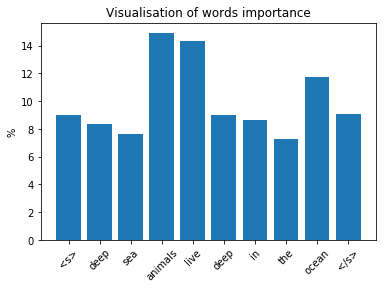

In [34]:
context_sent = 'deep sea animals live deep in the ocean'
_, _ = model.visualize(context_sent)

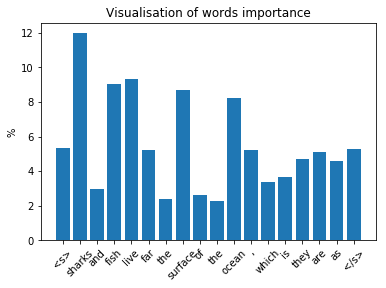

In [35]:
my_question = 'Frilled sharks and angler fish live far beneath the surface of the ocean, which is why they are known as.'
_, _ = model.visualize(my_question)

In [31]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [106]:
cosine(model.encode(['Frilled sharks and angler fish live far beneath the surface of the ocean, which is why they are known as.'])[0], model.encode(['deep sea animals live deep in the ocean'])[0])

0.69112474

In [113]:
cosine(model.encode(['beneath the surface of the ocean'])[0], model.encode(['deep in the ocean'])[0])

0.79064053

In [75]:
with open('data/Embeddings/dict_embeddings.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings, handle)

with open('data/Embeddings/dict_embeddings_questions.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings_questions, handle)

with open('data/Embeddings/dict_embeddings_answers_optionA.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings_answers_optionA, handle)

with open('data/Embeddings/dict_embeddings_answers_optionB.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings_answers_optionB, handle)

with open('data/Embeddings/dict_embeddings_answers_optionC.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings_answers_optionC, handle)   

with open('data/Embeddings/dict_embeddings_answers_optionD.pickle', 'wb') as handle:
    pickle.dump(dict_embeddings_answers_optionD, handle)       